In [0]:
!pip install pycountry geonamescache unidecode

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
!pip install pandas

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%restart_python

In [0]:
spark.sql("USE CATALOG workspace")
spark.sql("USE SCHEMA default")


DataFrame[]

In [0]:
from datetime import datetime 
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col, to_timestamp, stack, expr, lit, split, sum, udf, regexp_replace, size
from pyspark.sql.types import TimestampType, StructField, StructType, StringType, DoubleType, IntegerType, ArrayType
import os

In [0]:
df_comments = spark.table("workspace.default.reddit_comments_travel_silver_layer")

In [0]:
import geonamescache

gc = geonamescache.GeonamesCache()

# Get country names
countries_name =  gc.get_countries_by_names()


def NER_func_city(word):
    res = gc.get_cities_by_name(word.capitalize())
    if res == []:
        return []
    else:
        # use res[0] to get first element
        first_key = next(iter(res[0])) # used next and iter to get first element in the dict res[0]
        country_code = res[0][first_key]["countrycode"] # used the key to get country code from the dict that found in res[0]
        country = gc.get_countries() # used this function to get countries by code
        country_name = country[country_code]['name'] # get the country name

    return country_name     

def NER_func_country(text):
    text = text.split(" ")
    countries = set()
    for word in text:
        #print(word)
        if word.capitalize() in countries_name:
            countries.add(word)
        else:
            val = NER_func_city(word)
            if val == []:
                continue
            else:

                countries.add(val) 
    return list(countries) 

 

In [0]:
df_comments = df_comments.withColumn("body", regexp_replace("body", r"[^a-zA-Z0-9 ]", " "))

In [0]:
udf_search_country = udf(NER_func_country, ArrayType(StringType()))

In [0]:
df_comments = df_comments.withColumn("country_name", udf_search_country(df_comments["body"]))

In [0]:
df_comments[["country_name","body"]].show(5, )

+--------------------+--------------------+
|        country_name|                body|
+--------------------+--------------------+
|   [Turkey, Croatia]|Notice  Are you a...|
|            [Canada]|London has severa...|
|[Canada, Monteneg...|As a Londoner  I ...|
|[United States, C...|If its the weeken...|
|[United States, C...|Nothing really ev...|
+--------------------+--------------------+
only showing top 5 rows


In [0]:
df_comments_2 = df_comments.filter(size(col("country_name")) > 0)

In [0]:
df_comments_2 = df_comments_2.select("*", explode(col("country_name")))
df_comments_2 = df_comments_2.drop(("country_name"))


In [0]:
df_comments_2 = df_comments_2.withColumnRenamed("col","country_name")

In [0]:
df_comments_2.show(5)

+----------+----------------+-----+-------------------+----------+----------+--------------------+------------+
|comment_id|          author|score|        created_utc| parent_id|   link_id|                body|country_name|
+----------+----------------+-----+-------------------+----------+----------+--------------------+------------+
|   n85i14a|   AutoModerator|    1|2025-08-11 18:17:49|t3_1mnkqmi|t3_1mnkqmi|Notice  Are you a...|     Croatia|
|   n85i14a|   AutoModerator|    1|2025-08-11 18:17:49|t3_1mnkqmi|t3_1mnkqmi|Notice  Are you a...|      Turkey|
|   n85fd9z|NewJerseyAggie13|    1|2025-08-11 18:04:40|t3_1mnkabx|t3_1mnkabx|London has severa...|      Canada|
|   n85gih8|           ZKH15|    1|2025-08-11 18:10:18|t3_1mnkabx|t3_1mnkabx|As a Londoner  I ...|     Czechia|
|   n85gih8|           ZKH15|    1|2025-08-11 18:10:18|t3_1mnkabx|t3_1mnkabx|As a Londoner  I ...|      Turkey|
+----------+----------------+-----+-------------------+----------+----------+--------------------+------

In [0]:
df_comments_2.write.format("delta").mode("overwrite").saveAsTable(f"workspace.default.reddit_comments_travel_gold_layer")

# Applying some Aggregations on data

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
df_comments_pandas = df_comments_2.toPandas()

In [0]:
df_countries = df_comments_pandas.groupby(by=["country_name"])["comment_id"].agg("count").reset_index()

In [0]:
df_countries = df_countries.rename(columns={'comment_id':"countries_count"})
df_countries.head()

,country_name,countries_count
0,Albania,1
1,Argentina,4
2,Australia,5
3,Austria,6
4,Belgium,3


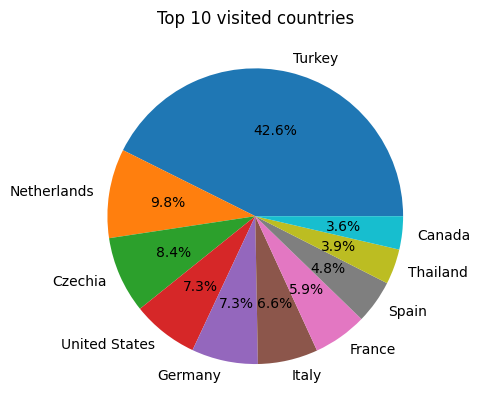

In [0]:
top_10_countries = df_countries.sort_values(by="countries_count",ascending=False).head(10)
ax = top_10_countries.plot(y='countries_count', labels=top_10_countries['country_name'],autopct='%1.1f%%',
                     kind='pie', title='Top 10 visited countries',legend=False)
ax.yaxis.set_visible(False)
plt.show()


In [0]:
df_countries.loc[df_countries['countries_count'] > 6].sort_values(by="countries_count",ascending=True).head(10)

,country_name,countries_count
46,Peru,7
68,United Kingdom,7
12,Croatia,7
27,India,7
47,Philippines,8
71,Vietnam,8
26,Iceland,9
10,China,10
67,United Arab Emirates,10
49,Portugal,11


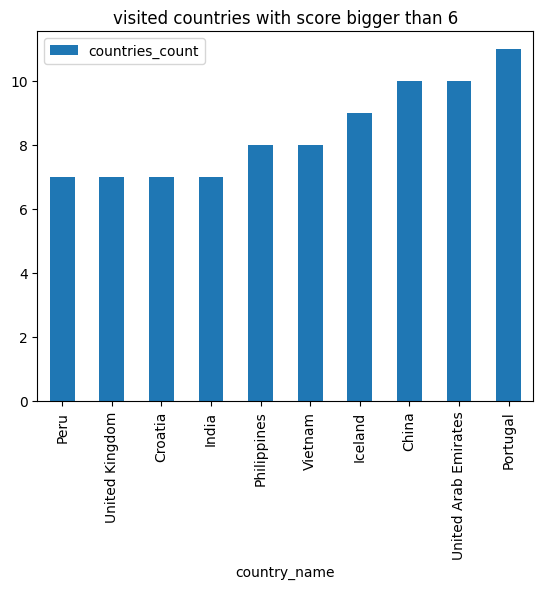

In [0]:
lowest_10_countries = df_countries.loc[df_countries['countries_count'] > 6].sort_values(by="countries_count",ascending=True).head(10)
lowest_10_countries.plot(x='country_name', y='countries_count', kind='bar', title='visited countries with score bigger than 6')
plt.show()

In [0]:
avg_score = df_comments_pandas["score"].mean()
max_score = df_comments_pandas["score"].max()
min_score = df_comments_pandas["score"].min()
avg_score,max_score,min_score

(3.4765395894428153, 83, -4)

In [0]:
top_10_scores = df_comments_pandas[["score","comment_id","author"]].sort_values(by="score",ascending=False).head(10)
top_10_scores

,score,comment_id,author
380,83,n83r1u4,pulisick38
381,83,n83r1u4,pulisick38
473,51,n83o7mp,coaxui
474,51,n83o7mp,coaxui
331,41,n840e7s,pabloelbuho
630,33,n82tz3i,bungopony
629,33,n82tz3i,bungopony
628,33,n82tz3i,bungopony
471,31,n83oqbd,NoZombie2069
143,28,n84fb6y,Zach06


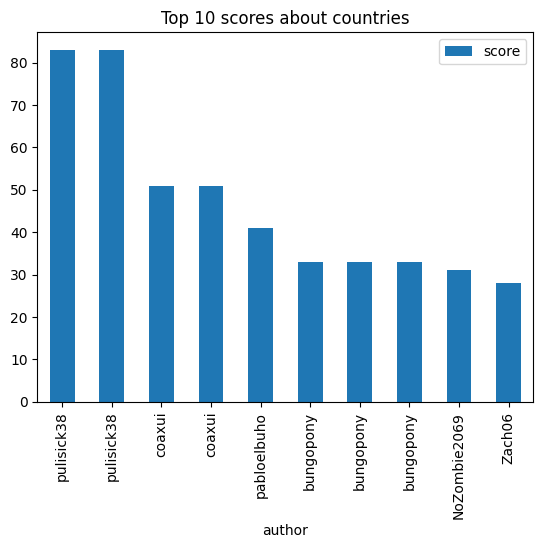

In [0]:
top_10_scores.plot(x='author', y='score', kind='bar', rot=90, title='Top 10 scores about countries')
plt.show()

In [0]:
lowest_10_scores = df_comments_pandas[["score","comment_id","author"]].sort_values(by="score",ascending=True).head(10)
lowest_10_scores

,score,comment_id,author
71,-4,n8565s9,David-J
70,-4,n8565s9,David-J
617,-4,n83iu5n,boneyqueenofnowhere
618,-4,n83iu5n,boneyqueenofnowhere
362,-4,n84cyjj,idkdudess
502,-3,n83m8mv,Afuturecruiser
504,-3,n83m8mv,Afuturecruiser
505,-3,n83m8mv,Afuturecruiser
506,-3,n83m8mv,Afuturecruiser
507,-3,n83m8mv,Afuturecruiser
